## Introduction to Time Series and Forecasting

Based on the book [Introduction to Time Series and Forecasting](http://www.masys.url.tw/Download/2002-Brockwell-Introduction%20Time%20Series%20and%20Forecasting.pdf) by Brockwell and Davis


### Examples of Time Series



In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [141]:
# This is just to select the style of the generated plots. Feel free to experiment
# and select other styles that you may like better. Notice that Style sheets are 
# designed to be composed together. So you can have a style sheet that customizes 
# colors and a separate style sheet that alters element sizes for presentations. 
# print(plt.style.available)
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

### Australian red wine "sales", (thousands of litres) monthly, Jan 80 - Oct 91

The file `australian-wine-sales.txt` contains the monthly sales of Australian red wines in for the period Jan-1980 to Oct-1991. Let's take a peak at the data file:

In [142]:
!head -5 /data/australian-wine-sales.txt

Date	Sales
Jan-80	464
Feb-80	675
Mar-80	703
Apr-80	887


In [143]:
!tail -5 /data/australian-wine-sales.txt

Jun-91	1892
Jul-91	2920
Aug-91	2572
Sep-91	2617
Oct-91	2047

In [144]:
!wc -l /data/australian-wine-sales.txt

142 /data/australian-wine-sales.txt


We will use Pandas and the `read_csv` function to read the text file into a dataframe.

In [145]:
df = pd.read_csv("/data/australian-wine-sales.txt", sep='\t')

In [146]:
df.head(5)

,Date,Sales
0,Jan-80,464
1,Feb-80,675
2,Mar-80,703
3,Apr-80,887
4,May-80,1139


Pandas is relatively smart and can infer the data type of a column.  

In [147]:
df.dtypes

Date     object
Sales     int64
dtype: object

In this case pandas figured out that `Sales` is a number, but not that `Date` is a date. 

We can now try to plot directly the contents of the dataframe.

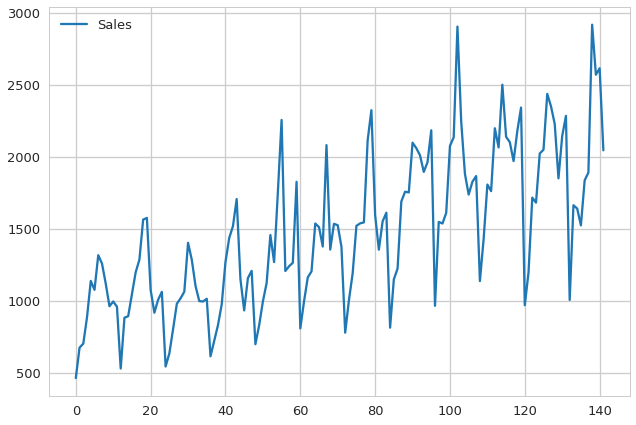

In [148]:
df.plot()

The plot would look better if we had the x-axis to be a date, instead of a number. For that, we use the corresponding Pandas functions to convert the columns into the appropriate formats. We also tell Pandas to convert the `Date` column into the key for each row.

In [149]:
# See https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior for parsing dates
# In our case %b is "Month as locale’s abbreviated name." and %y is "Year without century as a zero-padded decimal number."
df["Date"] = pd.to_datetime(df["Date"], format='%b-%y')
df["Sales"] = pd.to_numeric(df["Sales"])
df.set_index(keys="Date", inplace=True)
df.head(5)

,Sales
Date,
1980-01-01,464
1980-02-01,675
1980-03-01,703
1980-04-01,887
1980-05-01,1139


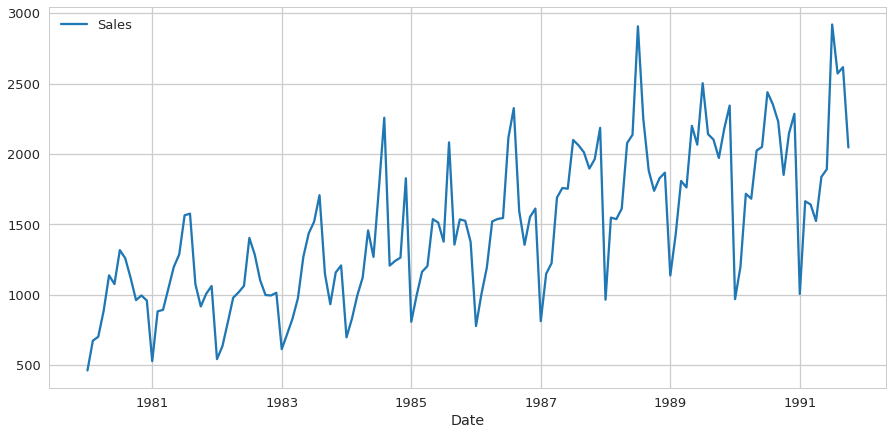

In [150]:
df.plot(figsize=(15,7), grid=True)

It appears from the graph that the sales have an upward trend and a seasonal pattern with a peak in July and a trough in January.

#### Jumping Ahead: Lag plots, autocorrelation plots, and decompositions.

Pandas provides two types of plots that can be used for the analysis of time series: the `lag_plot` and the `autocorrelation_plot`. We can also use the seasonal decomposition functionality of `statsmodels` to separate the time series into a trend, seasonal component, and residual noise. We will go quickly over these for now, mainly for demo purposes. Proper treatment of these topics require deeper analysis.



##### Lag plot

The lag plot shows the value of the series at time $t$ vs. its value at time $t+1$. If there is no dependency (i.e., the time series is noise) then the lag plot is a scatterplot without any sign of correlation. If we can see a pattern and a correlation, then the series exhibits autocorrelation. For example, below we can see that there is a rather strong correlation of the two variables, indicating that the sales in time $t+1$ is similar to the sales at time $t$.

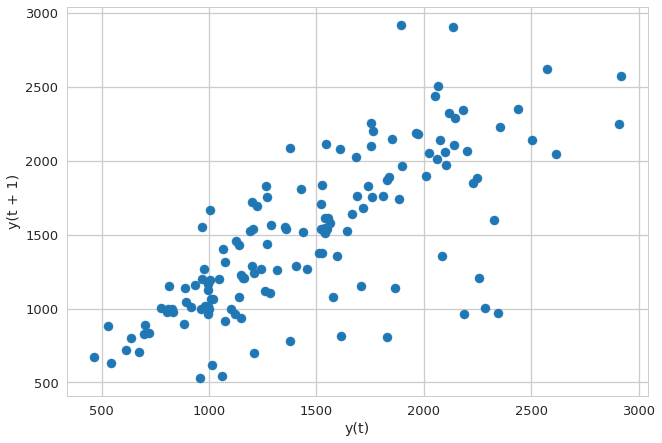

In [151]:
from pandas.plotting import lag_plot
lag_plot(df["Sales"])

##### Autocorrelation Plot

In a more general setting, we want to also see if the value of the series at time $t$ is predictive of the value at time $t+n$. Such dependency would indicate that there is *autocorrelation* in the series. The autocorrelation plot shows the correlation value for various values of $n$.

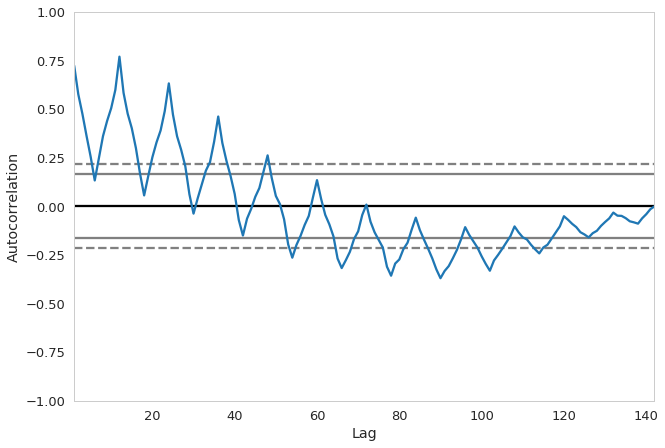

In [152]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df["Sales"])

##### Trend/Seasonal Decomposition



<Figure size 748.8x514.8 with 0 Axes>

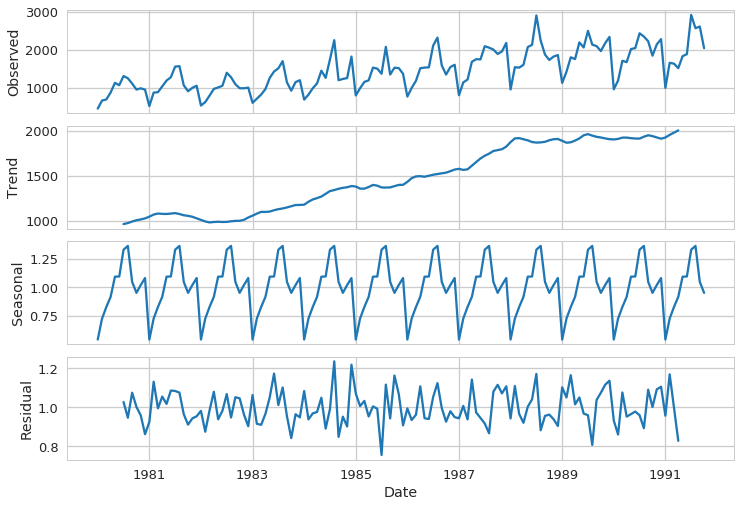

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose assumming a 12-month periodicity. 
# There is a weekly component as well, which we ignore.
# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
decomposition = seasonal_decompose(df['Sales'], model='multiplicative', freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  

#### Accessing indinvidual components of the decomposition

Once we have the decomposed time series model, we can also access the different components.

For example, we can get the trend of the time series, after removing the seasonality component:

In [114]:
# The outcome is a pandas Series, which is effectively the same as a single column of dataframe
decomposition.trend

Date
1980-01-01            NaN
1980-02-01            NaN
1980-03-01            NaN
1980-04-01            NaN
1980-05-01            NaN
1980-06-01            NaN
1980-07-01     966.250000
1980-08-01     977.666667
1980-09-01     994.291667
1980-10-01    1008.833333
1980-11-01    1017.916667
1980-12-01    1029.166667
1981-01-01    1048.208333
1981-02-01    1071.708333
1981-03-01    1083.083333
1981-04-01    1079.375000
1981-05-01    1078.000000
1981-06-01    1082.791667
1981-07-01    1087.666667
1981-08-01    1077.916667
1981-09-01    1063.833333
1981-10-01    1057.375000
1981-11-01    1047.125000
1981-12-01    1030.291667
1982-01-01    1014.291667
1982-02-01     995.458333
1982-03-01     984.500000
1982-04-01     989.041667
1982-05-01     991.916667
1982-06-01     989.416667
                 ...     
1989-05-01    1916.541667
1989-06-01    1951.083333
1989-07-01    1963.916667
1989-08-01    1947.291667
1989-09-01    1933.875000
1989-10-01    1926.750000
1989-11-01    1916.125000
1989-12

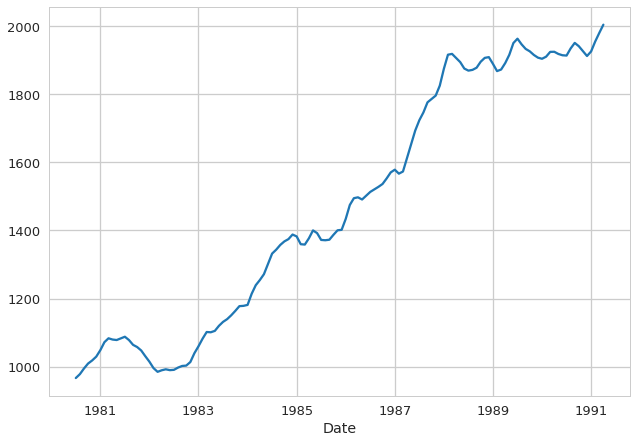

In [115]:
decomposition.trend.plot()

### The monthly accidental deaths data, 1973–1978

In [116]:
!cat /data/acc-deaths.txt

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
1973  9007  8106  8928  9137 10017 10826 11317 10744  9713  9938  9161  8927
1974  7750  6981  8038  8422  8714  9512 10120  9823  8743  9129  8710  8680
1975  8162  7306  8124  7870  9387  9556 10093  9620  8285  8466  8160  8034
1976  7717  7461  7767  7925  8623  8945 10078  9179  8037  8488  7874  8647
1977  7792  6957  7726  8106  8890  9299 10625  9302  8314  8850  8265  8796
1978  7836  6892  7791  8192  9115  9434 10484  9827  9110  9070  8633  9240

This is a different type format that the file that we had before. First of all, we have _fixed width_ columns, and not a tab-separated file. So instead of using the `read_csv` command, we will use the `read_fwf` command to read the data.

In [117]:
df = pd.read_fwf("/data/acc-deaths.txt")
df.set_index('Year')

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1973,9007,8106,8928,9137,10017,10826,11317,10744,9713,9938,9161,8927
1974,7750,6981,8038,8422,8714,9512,10120,9823,8743,9129,8710,8680
1975,8162,7306,8124,7870,9387,9556,10093,9620,8285,8466,8160,8034
1976,7717,7461,7767,7925,8623,8945,10078,9179,8037,8488,7874,8647
1977,7792,6957,7726,8106,8890,9299,10625,9302,8314,8850,8265,8796
1978,7836,6892,7791,8192,9115,9434,10484,9827,9110,9070,8633,9240


##### Melt and Pivot_Table

Now we want to take the month-columns, and convert the file into a file with the format `<date>`, `<value>`.

The command for this is the [melt](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) command. (For the opposite operation, use the [pivot_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) function.)

In [118]:
df = pd.melt(df, id_vars=['Year'], 
        value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        var_name='Month', value_name='Deaths')
df.head(10)

,Year,Month,Deaths
0,1973,Jan,9007
1,1974,Jan,7750
2,1975,Jan,8162
3,1976,Jan,7717
4,1977,Jan,7792
5,1978,Jan,7836
6,1973,Feb,8106
7,1974,Feb,6981
8,1975,Feb,7306
9,1976,Feb,7461


In [119]:
df.pivot_table(
    index='Year',
    columns='Month',
    values = 'Deaths'

)

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
1973,9137,10744,8927,8106,9007,11317,10826,8928,10017,9161,9938,9713
1974,8422,9823,8680,6981,7750,10120,9512,8038,8714,8710,9129,8743
1975,7870,9620,8034,7306,8162,10093,9556,8124,9387,8160,8466,8285
1976,7925,9179,8647,7461,7717,10078,8945,7767,8623,7874,8488,8037
1977,8106,9302,8796,6957,7792,10625,9299,7726,8890,8265,8850,8314
1978,8192,9827,9240,6892,7836,10484,9434,7791,9115,8633,9070,9110


Now, we want to merge the month and year columns, to create a Date column.

In [120]:
# Notice the use of .astype(str) function that converts the int64 datatype into a string.
# Without that function, we get an error message that we cannot add an integer (Year) with a string (Month)
df["Date"] = df["Month"] + "-" + df["Year"].astype(str)
df

,Year,Month,Deaths,Date
0,1973,Jan,9007,Jan-1973
1,1974,Jan,7750,Jan-1974
2,1975,Jan,8162,Jan-1975
3,1976,Jan,7717,Jan-1976
4,1977,Jan,7792,Jan-1977
5,1978,Jan,7836,Jan-1978
6,1973,Feb,8106,Feb-1973
7,1974,Feb,6981,Feb-1974
8,1975,Feb,7306,Feb-1975
9,1976,Feb,7461,Feb-1976


In [121]:
df.dtypes

Year       int64
Month     object
Deaths     int64
Date      object
dtype: object

In [122]:
df["Date"] = pd.to_datetime(df["Date"], format='%b-%Y')
df

,Year,Month,Deaths,Date
0,1973,Jan,9007,1973-01-01
1,1974,Jan,7750,1974-01-01
2,1975,Jan,8162,1975-01-01
3,1976,Jan,7717,1976-01-01
4,1977,Jan,7792,1977-01-01
5,1978,Jan,7836,1978-01-01
6,1973,Feb,8106,1973-02-01
7,1974,Feb,6981,1974-02-01
8,1975,Feb,7306,1975-02-01
9,1976,Feb,7461,1976-02-01


Now, that we have the Date column, we can delete the month and year columns. Notice the `axis='columns'` part: this means that we drop a _column_ with that name. If we used `axis='rows'`, then Pandas would have been looking for a _row_ with that key to drop.

In [123]:
df.drop("Month", axis='columns', inplace=True)
df.drop("Year", axis='columns', inplace=True)

And now we convert the `Date` to be an index, so that it can be used as the x-axis for plotting the series.

In [124]:
df.set_index(keys="Date", inplace=True)

In [125]:
df.head(5)

,Deaths
Date,
1973-01-01,9007
1974-01-01,7750
1975-01-01,8162
1976-01-01,7717
1977-01-01,7792


Notice that the dates are not in order (we get the January's for all the years first, then the February's etc). While this is not an issue with plotting, this can be an issue for other types of analyses. For this reason, we sort the index:

In [126]:
df.sort_index(inplace=True)

In [127]:
df.head(5)

,Deaths
Date,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017


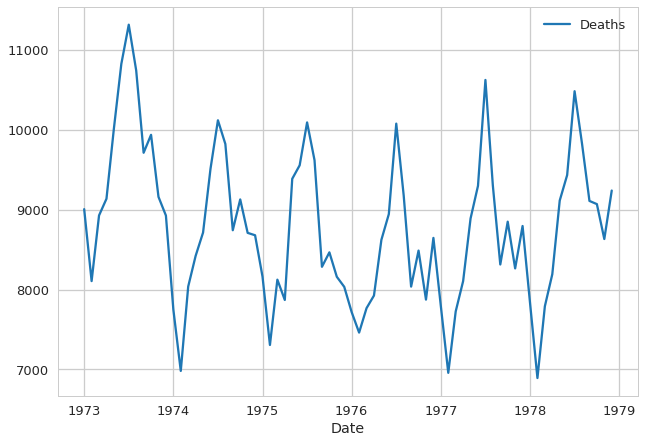

In [128]:
df.plot()

Like the red wine sales, the monthly accidental death ﬁgures show a strong seasonal pattern, with the maximum for each year occurring in July and the minimum for each year occurring in February. The presence of a trend  is much less apparent than in the wine sales. Later in this module, we will how we often represent the data as the sum of a trend, a seasonal component, and a residual term.

#### Exercise

* Perform a decomposition of the time series into a trend, seasonal, and residual component.
* Try out both the additive and the multiplicative approach for the decomposition. Try to interpret and understand the difference in the reported seasonal component.
* Extract the trend for the accidental deaths.

<Figure size 748.8x514.8 with 0 Axes>

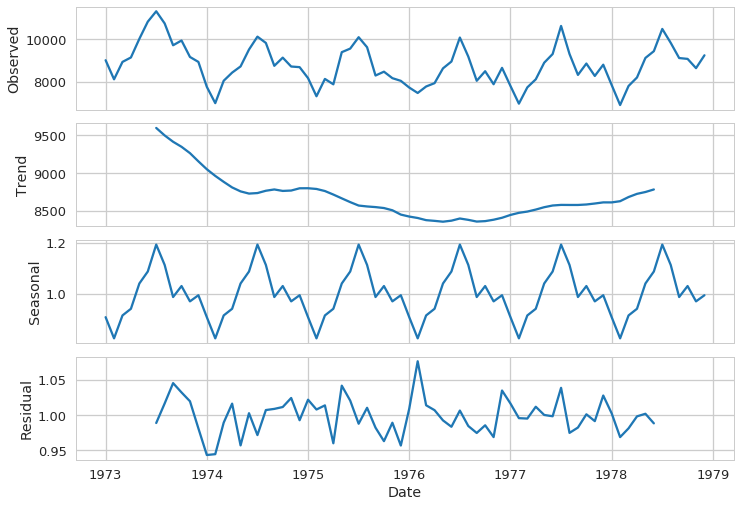

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose assumming a 12-month periodicity. 
# There is a weekly component as well, which we ignore.
# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
decomposition = seasonal_decompose(df['Deaths'], model='multiplicative', freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  

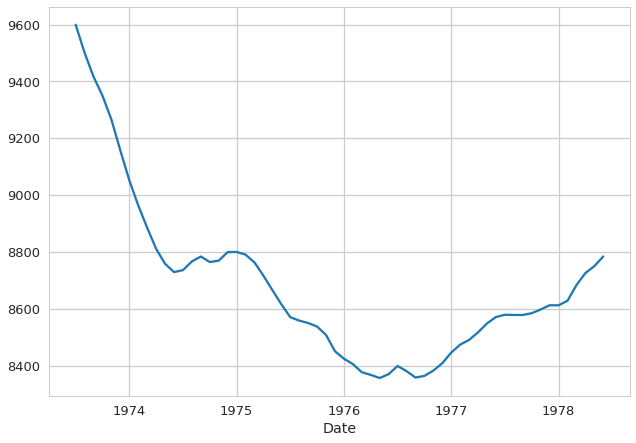

In [133]:
# Extracting the deaths trend component
decomposition.trend.plot()

#### Advanced: Time Series Window operations: Rolling / Expanding / EW

One question that comes up when we have a periodic time series is: "How can I figure out the overall trend?". In the examples above, we relied on a "black box" where we simply asked for the time series to be decomposed into a trend, seasonal, and residual component. Now, let's dig a bit deeper on how we can extract trend components that are unaffected by seasonality.

For that, we often rely on "window" functions, that operate over a set of continuous time series points. For example, if we have a time series that has a 12-month seasonality, we can take the 12-month average, which will not exhibit seasonality, but will capture the trend. 

These windows functions are common time series operations. Pandas provides support for various types of windows. Here are a few that are commonly used: 
* [Rolling window](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html): We compute the function over a time period equal to a window
* [Expanding](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.expanding.html): We compute the function over a period of 1, 2, 3,... instances.
* [Exponential weighting](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html): We keep a window of a fixed size but we weight less and less (exponentially) the old data points.

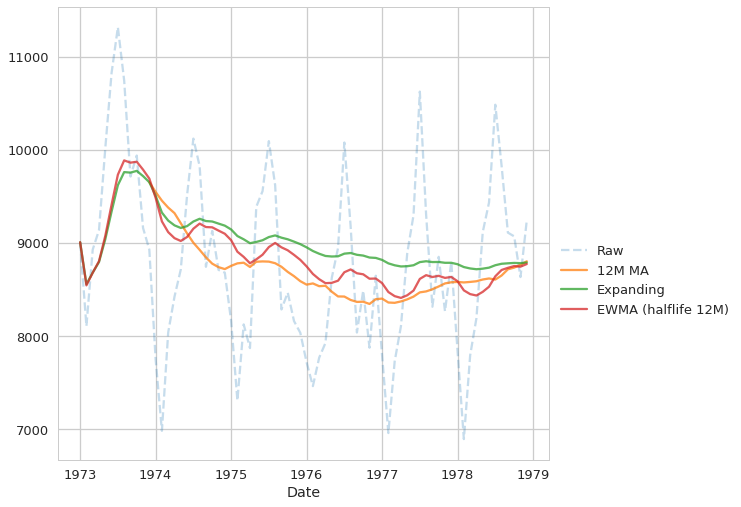

In [139]:
# Notice that we use the idiom df.Deaths instead of df['Deaths']. 
# The two are equivalent

# Use different linestyle, and use high alpha to make the series less visually prominent
df.Deaths.plot(label='Raw', linestyle ="--", alpha=0.25)

# Plot the 12-month moving average
df.Deaths.rolling(12).mean().plot(label='12M MA', alpha=0.75)

# Plot the expanding mean. This is the mean of the series from the beginning till that point in time
df.Deaths.expanding().mean().plot(label='Expanding', alpha=0.75)

# Plot the exponentially weighted moving average. This moving average weighs more heavily the newer
# data points and weighs less the old ones. 
df.Deaths.ewm(halflife=12).mean().plot(label='EWMA (halflife 12M)', alpha=0.75)

# places the legend to the right side (1) and middle of the y-axis (0.5)
plt.legend(bbox_to_anchor=(1, .5)) 
plt.tight_layout()

### US Strikes (1968-1976) and economic output

The data is the same data as originally used in J. Kennan, "The Duration of Contract strikes in U.S. Manufacturing", 
Journal of Econometrics, 1985, Vol. 28, pp.5-28. The data is monthly U.S. data from 1968(1) to 1976(12).

* STRIKES is number of strikes (number of contract strikes in U.S. manufacturing beginning each month) 
* OUTPUT is level of economic activity (measured as cyclical departure of aggregate production from its trend level) 


In [ ]:
!head -20 /data/strikes.tsv

In [ ]:
df = pd.read_csv("/data/strikes.tsv", sep='\t')
df.head(5)

In [ ]:
df.dtypes

In [ ]:
df["DATE"] = pd.to_datetime(df["DATE"], format='%b-%y')

In [ ]:
df.head(15)

Oops, we have a problem. According to https://docs.python.org/2/library/time.html when we have a 2-digit year, "_values 69-99 are mapped to 1969-1999, and values 0–68 are mapped to 2000–2068_". 

We now need to write a function that will edit the year-parsing problem.

In [ ]:
from pandas.tseries.offsets import DateOffset

def fix_year(dt):
    if dt.year > 2050:
        return dt - DateOffset(years=100)
    else:
        return dt

And then apply the function to the dataframe column using the `apply` command.

In [ ]:
df["DATE"] = df["DATE"].apply(fix_year)
df.head(15)

_Note: We can also fix that issue by replacing the 2-digit year with a 4-digit value, and then proceed as usual. We can do that using "**regular expressions**", which we will discuss later on. For reference, here is the command, which will look super cryptic right now, but will be easy to understand later on._

```python 
df.DATE = df.DATE.astype(str).replace(to_replace = '(\w{3})-(\d{2})', value=r'\1-19\2', regex=True )
```


In [ ]:
df.set_index(keys="DATE", inplace=True)
df.sort_index(inplace=True)

In [ ]:
df.STRIKES.plot()

In [ ]:
df.OUTPUT.plot()

#### Exercise

* Perform a decomposition of the time series above (strikes and output)
* Is there a significant seasonality component?



### US Population Recorded by the US Census

In [ ]:
!head -5 /data/us-population2.txt

In [ ]:
# We use the thousands=',' option to properly convert the population numbers to integers
df = pd.read_csv("/data/us-population2.txt", sep=' ', thousands=',')
df["Year"] = pd.to_numeric(df["Year"])
df["US_Population"] = pd.to_numeric(df["US_Population"])
df.set_index(keys="Year", inplace=True)

df.plot()

#### Level of Lake Huron 1875--1972 

Annual measurements of the level, in feet, of Lake Huron 1875--1972

In [ ]:
!head -5 /data/lake-huron.txt

In [ ]:
df = pd.read_csv("/data/lake-huron.txt", sep='\t')
df.set_index(keys="Year", inplace=True)
df.plot()